# DFS2 - Export to NetCDF

In [1]:
# pip install mikeio xarray netcdf4

In [2]:
import mikeio
import xarray as xr
import numpy as np

In [3]:
ds = mikeio.read("../tests/testdata/gebco_sound.dfs2")

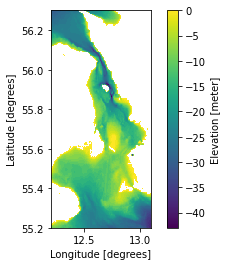

In [4]:
ds.Elevation.plot();

The simplest approach is to use the `Dataset.to_xarray()` or `DataArray.to_xarray()` method, if no custom information is neeeded.

In [5]:
xr_ds = ds.to_xarray()
xr_ds

<xarray.Dataset>
Dimensions:    (time: 1, x: 216, y: 264)
Coordinates:
  * time       (time) datetime64[ns] 2020-05-15T11:04:52
  * x          (x) float64 12.2 12.21 12.21 12.21 ... 13.09 13.09 13.09 13.1
  * y          (y) float64 55.2 55.21 55.21 55.21 ... 56.29 56.29 56.29 56.3
Data variables:
    Elevation  (time, y, x) float32 -8.0 -8.0 -8.0 -8.0 -9.0 ... nan nan nan nan

In [6]:
xr_da = ds.Elevation.to_xarray()
xr_da

<xarray.DataArray 'Elevation' (time: 1, y: 264, x: 216)>
array([[[ -8.,  -8.,  -8., ..., -37., -38., -38.],
        [ -7.,  -7.,  -7., ..., -38., -38., -38.],
        [ -5.,  -6.,  -6., ..., -37., -38., -38.],
        ...,
        [-30., -30., -30., ...,  nan,  nan,  nan],
        [-30., -30., -30., ...,  nan,  nan,  nan],
        [-31., -30., -31., ...,  nan,  nan,  nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2020-05-15T11:04:52
  * x        (x) float64 12.2 12.21 12.21 12.21 12.22 ... 13.09 13.09 13.09 13.1
  * y        (y) float64 55.2 55.21 55.21 55.21 55.22 ... 56.29 56.29 56.29 56.3
Attributes:
    name:     Elevation
    units:    meter
    eumType:  EUMType.Total_Water_Depth
    eumUnit:  EUMUnit.meter

Save it as a NetCDF file:

In [7]:
xr_da.to_netcdf("gebco_std.nc")

## Customized NetCDF

1. Time-invariant file -> remove time dimension
2. Rename y, x to lat, lon
3. Lowercase names
4. Add other metadata

In [8]:
x = ds.geometry.x
y = ds.geometry.y

In [9]:
res = {}

spdims = ["lat", "lon"]

if len(ds.time) > 1:
    dims = ["t"] + spdims
    coords = {"t": ds.time}
else:
    dims = spdims
    coords = {}
    
coords["lon"] = xr.DataArray(x, dims="lon", attrs={"standard_name" : "longitude", "units" : "degrees_east"})
coords["lat"] = xr.DataArray(y, dims="lat", attrs={"standard_name" : "latitude", "units" : "degrees_north"})

for da in ds:
    name = da.name.lower()
    res[name] = xr.DataArray(np.squeeze(da.to_numpy()), dims=dims, 
    attrs={'name': name,
            # TODO add standard name from https://cfconventions.org/standard-names.html
            'units': da.unit.name,
            'eumType' : da.type,
            'eumUnit' : da.unit})        

xr_ds = xr.Dataset(res, coords=coords, attrs={'title': 'Converted from Dfs2 by MIKE IO'})


In [10]:
xr_ds

<xarray.Dataset>
Dimensions:    (lat: 264, lon: 216)
Coordinates:
  * lon        (lon) float64 12.2 12.21 12.21 12.21 ... 13.09 13.09 13.09 13.1
  * lat        (lat) float64 55.2 55.21 55.21 55.21 ... 56.29 56.29 56.29 56.3
Data variables:
    elevation  (lat, lon) float32 -8.0 -8.0 -8.0 -8.0 -9.0 ... nan nan nan nan
Attributes:
    title:    Converted from Dfs2 by MIKE IO

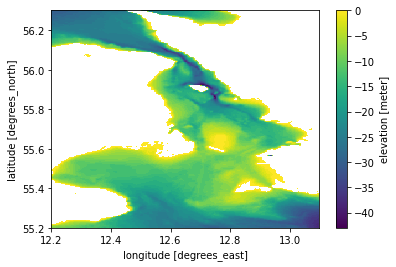

In [11]:
xr_ds.elevation.plot();

In [12]:
xr_ds.to_netcdf("gebco.nc")

# Clean up

In [13]:
import os
os.remove("gebco_std.nc")
os.remove("gebco.nc")